In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import numpy as np
import os
from random import seed
import pickle
import yaml
import imageio

from src.modules.vqvae import VQVae
from src.modules.res_vqvae import ResVQVae
from train_tokenizer import VQVAEModule
from src.dataset import Dataset
from IPython.display import Image, display
import matplotlib.pyplot as plt

/home/xabieririzar/liveportrait-tokenizer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pickle_dir = Path("dataset/pickles")

In [4]:
model_path = Path("outputs/20250515_201145-vqvae-test-lr1e-4-bs32-e1000/checkpoints/checkpoint_epoch=189.ckpt")
pretrained = torch.load(model_path)

if model_path.suffix == '.ckpt':
    config_path = model_path.parent.parent / 'wandb' / 'latest-run' / 'files' / 'config.yaml'
else:
    config_path = model_path.parent / 'wandb' / 'latest-run' / 'files' / 'config.yaml'

config = yaml.safe_load(open(config_path, "r"))
feats_enabled = config['feats_enabled']['value']

print([feat for feat in feats_enabled.keys() if feats_enabled[feat]['enabled']])
vqvae = None
if model_path.suffix == '.ckpt':
    vqvae_module = VQVAEModule(vqvae_config=config["vqvae"]['value'], losses_config=config["losses"])
    vqvae_module.load_state_dict(pretrained['state_dict'])
    vqvae = vqvae_module.vqvae
else:
    vqvae = VQVae(**config["vqvae"]['value'])
    vqvae.load_state_dict(pretrained)

vqvae.to("cuda")
vqvae.eval()
print()

['exp']



In [5]:
ds = Dataset("dataset", split="eval", compute_stats=False)

Loading precomputed statistics from dataset/stats_all.pkl
Loaded feature-wise statistics successfully
Loaded 650 eval samples


KP shape: torch.Size([254, 1, 21, 3]), EXP shape: torch.Size([254, 1, 21, 3])
KP - Number of frames: 254, Keypoints: 21, Dimensions: 3
EXP - Number of frames: 254, Keypoints: 21, Dimensions: 3


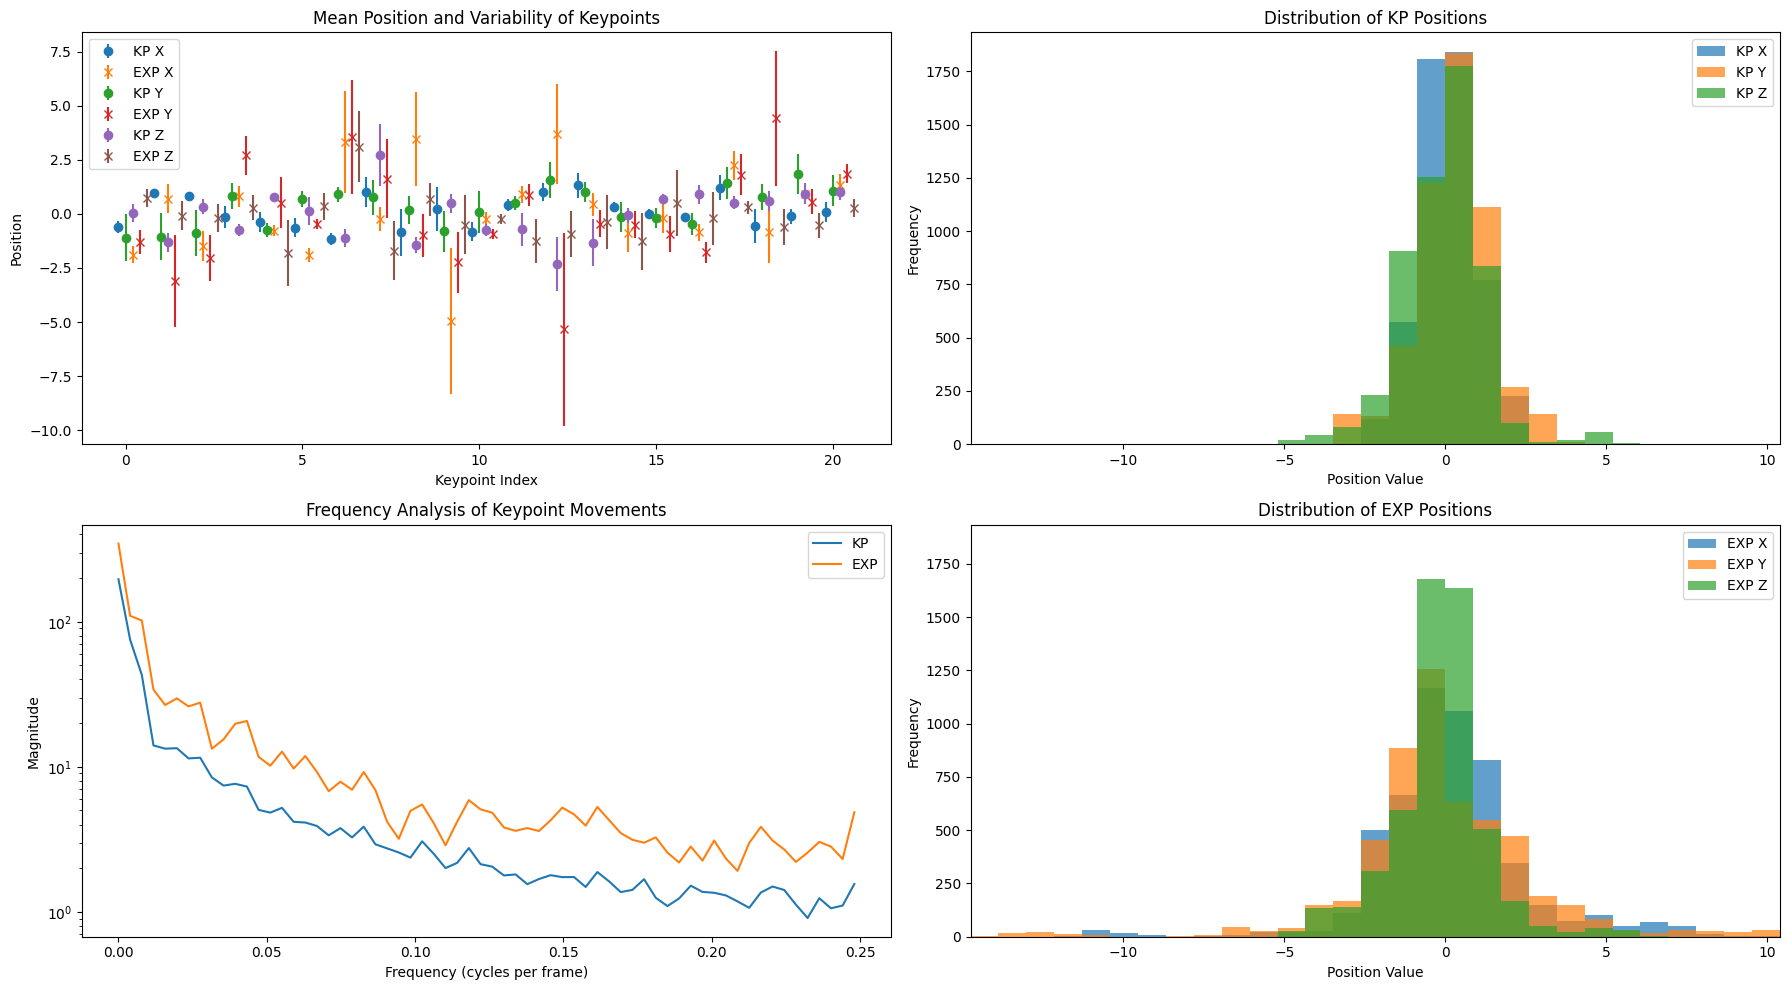

In [6]:
# Get the keypoints data
kp_data = ds[0]['kp']
exp_data = ds[0]['exp']
print(f"KP shape: {kp_data.shape}, EXP shape: {exp_data.shape}")

# Create a figure with subplots for different visualizations
fig = plt.figure(figsize=(18, 10))

# Calculate various statistics for both kp and exp
num_frames_kp, batch_size_kp, num_keypoints_kp, dims_kp = kp_data.shape
num_frames_exp, batch_size_exp, num_keypoints_exp, dims_exp = exp_data.shape

print(f"KP - Number of frames: {num_frames_kp}, Keypoints: {num_keypoints_kp}, Dimensions: {dims_kp}")
print(f"EXP - Number of frames: {num_frames_exp}, Keypoints: {num_keypoints_exp}, Dimensions: {dims_exp}")

# Calculate statistics across all keypoints for both kp and exp
mean_position_kp = kp_data.mean(dim=(0, 1))
std_position_kp = kp_data.std(dim=(0, 1))
min_position_kp = kp_data.min(dim=0)[0].min(dim=0)[0]
max_position_kp = kp_data.max(dim=0)[0].max(dim=0)[0]

mean_position_exp = exp_data.mean(dim=(0, 1))
std_position_exp = exp_data.std(dim=(0, 1))
min_position_exp = exp_data.min(dim=0)[0].min(dim=0)[0]
max_position_exp = exp_data.max(dim=0)[0].max(dim=0)[0]

# Calculate movement statistics for both kp and exp
frame_to_frame_movement_kp = torch.sqrt(torch.sum(
    (kp_data[1:] - kp_data[:-1])**2, dim=3
)).mean(dim=1)

frame_to_frame_movement_exp = torch.sqrt(torch.sum(
    (exp_data[1:] - exp_data[:-1])**2, dim=3
)).mean(dim=1)

# Calculate total movement per keypoint for both kp and exp
keypoint_movement_kp = torch.zeros(num_keypoints_kp)
for i in range(num_keypoints_kp):
    diffs = torch.diff(kp_data[:, 0, i, :], dim=0)
    keypoint_movement_kp[i] = torch.sum(torch.sqrt(torch.sum(diffs**2, dim=1)))

keypoint_movement_exp = torch.zeros(num_keypoints_exp)
for i in range(num_keypoints_exp):
    diffs = torch.diff(exp_data[:, 0, i, :], dim=0)
    keypoint_movement_exp[i] = torch.sum(torch.sqrt(torch.sum(diffs**2, dim=1)))

# 1. Plot the mean and std of keypoint positions for both kp and exp
ax1 = fig.add_subplot(221)
x = np.arange(num_keypoints_kp)
for i, dim_name in enumerate(['X', 'Y', 'Z']):
    ax1.errorbar(x + i*0.2 - 0.2, mean_position_kp[:, i].numpy(), 
                yerr=std_position_kp[:, i].numpy(), fmt='o', label=f'KP {dim_name}')
    ax1.errorbar(x + i*0.2 + 0.2, mean_position_exp[:, i].numpy(), 
                yerr=std_position_exp[:, i].numpy(), fmt='x', label=f'EXP {dim_name}')
ax1.set_title('Mean Position and Variability of Keypoints')
ax1.set_xlabel('Keypoint Index')
ax1.set_ylabel('Position')
ax1.legend()

# 2. Plot the distribution of keypoint positions for both kp and exp
# Create two separate subplots for KP and EXP distributions
ax2a = fig.add_subplot(222)
ax2b = fig.add_subplot(224)

# Find global min and max across both datasets for consistent binning and axis scaling
global_min = min(min_position_kp.min().item(), min_position_exp.min().item())
global_max = max(max_position_kp.max().item(), max_position_exp.max().item())

# Create common bins for both datasets
common_bins = np.linspace(global_min, global_max, 30)

# Plot KP distributions
for i, dim_name in enumerate(['X', 'Y', 'Z']):
    # Flatten all keypoints for this dimension
    kp_values = kp_data[..., i].numpy().flatten()
    ax2a.hist(kp_values, bins=common_bins, alpha=0.7, label=f'KP {dim_name}')
ax2a.set_title('Distribution of KP Positions')
ax2a.set_xlabel('Position Value')
ax2a.set_ylabel('Frequency')
ax2a.set_xlim(global_min, global_max)
ax2a.legend()

# Plot EXP distributions
for i, dim_name in enumerate(['X', 'Y', 'Z']):
    # Flatten all keypoints for this dimension
    exp_values = exp_data[..., i].numpy().flatten()
    ax2b.hist(exp_values, bins=common_bins, alpha=0.7, label=f'EXP {dim_name}')
ax2b.set_title('Distribution of EXP Positions')
ax2b.set_xlabel('Position Value')
ax2b.set_ylabel('Frequency')
ax2b.set_xlim(global_min, global_max)
ax2b.legend()

# Ensure both histograms have the same y-axis scale
y_max = max(ax2a.get_ylim()[1], ax2b.get_ylim()[1])
ax2a.set_ylim(0, y_max)
ax2b.set_ylim(0, y_max)

# 3. Plot the spectral power of keypoint movements over time for both kp and exp
ax3 = fig.add_subplot(223)
# Compute FFT for each keypoint trajectory
fft_magnitudes_kp = []
fft_magnitudes_exp = []

for kp_idx in range(num_keypoints_kp):
    for dim_idx in range(dims_kp):
        # Get the trajectory for this keypoint and dimension
        trajectory_kp = kp_data[:, 0, kp_idx, dim_idx].numpy()
        trajectory_exp = exp_data[:, 0, kp_idx, dim_idx].numpy()
        # Apply FFT
        fft_result_kp = np.abs(np.fft.rfft(trajectory_kp))
        fft_result_exp = np.abs(np.fft.rfft(trajectory_exp))
        fft_magnitudes_kp.append(fft_result_kp)
        fft_magnitudes_exp.append(fft_result_exp)

# Average the FFT magnitudes across all keypoints and dimensions
avg_fft_magnitude_kp = np.mean(np.array(fft_magnitudes_kp), axis=0)
avg_fft_magnitude_exp = np.mean(np.array(fft_magnitudes_exp), axis=0)
# Create frequency axis (in cycles per frame)
freqs_kp = np.fft.rfftfreq(num_frames_kp)
freqs_exp = np.fft.rfftfreq(num_frames_exp)
# Plot only the first half of frequencies (more meaningful)
plot_limit_kp = len(freqs_kp) // 2
plot_limit_exp = len(freqs_exp) // 2
ax3.plot(freqs_kp[:plot_limit_kp], avg_fft_magnitude_kp[:plot_limit_kp], label='KP')
ax3.plot(freqs_exp[:plot_limit_exp], avg_fft_magnitude_exp[:plot_limit_exp], label='EXP')
ax3.set_title('Frequency Analysis of Keypoint Movements')
ax3.set_xlabel('Frequency (cycles per frame)')
ax3.set_ylabel('Magnitude')
ax3.set_yscale('log')  # Log scale to better visualize the power spectrum
ax3.legend()

plt.tight_layout()
plt.show()

### Prepare ds item

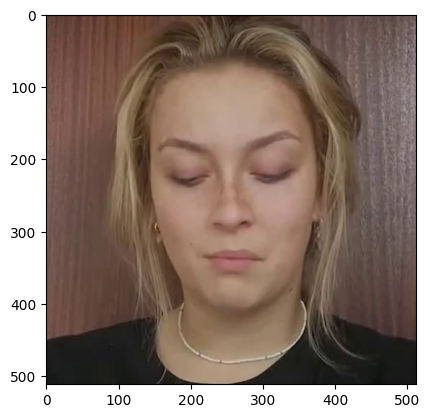

In [7]:
sample = ds[5]

pickle_path = sample['metadata']['pickle_path']
vid_id = pickle_path.split("/")[-1].split(".")[0]
vid_path = f"dataset/train/{vid_id}.mp4"

# Read the first frame from the video and display it
frame = imageio.get_reader(vid_path).get_data(0)
plt.imshow(frame)
plt.show()


In [8]:
sample['c_eyes_lst'].shape

torch.Size([599, 2])

In [9]:
frames = sample['kp'].shape[0]
fps = sample['metadata']['output_fps']
seq_len = min(sample['kp'].shape[0], 300)

# Initialize an empty tensor list to collect features
feature_tensors = []
dims = {}

for feat, metadata in feats_enabled.items():
    is_enabled = metadata['enabled']
    if is_enabled:
        print(f"Using {feat}")
        feature = sample[feat][:seq_len].reshape(1, seq_len, -1)
        dims[feat] = feature.shape[-1]
        feature_tensors.append(feature)

# Concatenate all enabled features
if feature_tensors:
    features = torch.concat(feature_tensors, dim=2)
else:
    # Create an empty tensor if no features are enabled
    features = torch.empty((1, seq_len, 0))

features = features.to("cuda")
print("dims: ", dims)


Using exp
dims:  {'exp': 63}


### Reconstruct feats

In [10]:
# Load stats
stats = pickle.load(open("dataset/stats_all.pkl", "rb"))

In [11]:
# Send stats to GPU
for key in stats['mean']:
    stats['mean'][key] = stats['mean'][key].to("cuda")
    stats['std'][key] = stats['std'][key].to("cuda")
std = stats['std']
mean = stats['mean']

In [12]:
ds[10]['exp'].mean(dim=0).shape

torch.Size([1, 21, 3])

In [13]:
# with torch.no_grad():
#     post = vqvae.preprocess(features)
#     encoded = vqvae.encoder(post)
#     encoded = vqvae.postprocess(encoded)

In [14]:
# x = encoded.contiguous().view(-1, encoded.shape[-1])

# k_w = vqvae.quantizer.codebook.t()

# distance = torch.sum(x ** 2, dim=-1, keepdim=True) - 2 * torch.matmul(x, k_w) + torch.sum(k_w ** 2, dim=0, keepdim=True)  # (N * L, b)
# _, code_idx = torch.min(distance, dim=-1)

In [15]:
# # Print the shape of distance
# print(distance.shape)

# # Visualize statistics about the distance
# plt.figure(figsize=(12, 8))

# # Plot 1: Histogram of minimum distances
# min_distances = torch.min(distance, dim=1)[0]
# plt.subplot(2, 2, 1)
# plt.hist(min_distances.cpu().numpy(), bins=50)
# plt.title('Histogram of Minimum Distances')
# plt.xlabel('Distance')
# plt.ylabel('Frequency')

# # Plot 2: Mean distance per codebook entry
# mean_distances = distance.mean(dim=0)
# plt.subplot(2, 2, 2)
# plt.plot(mean_distances.cpu().numpy())
# plt.title('Mean Distance per Codebook Entry')
# plt.xlabel('Codebook Index')
# plt.ylabel('Mean Distance')

# # Plot 3: Distribution of selected codes
# code_counts = torch.bincount(code_idx, minlength=vqvae.quantizer.codebook.shape[1])
# plt.subplot(2, 2, 3)
# plt.bar(range(len(code_counts)), code_counts.cpu().numpy())
# plt.title('Distribution of Selected Codes')
# plt.xlabel('Code Index')
# plt.ylabel('Count')

# # Plot 4: Heatmap of a sample of the distance matrix
# plt.subplot(2, 2, 4)
# sample_size = min(20, distance.shape[0])
# sample_codes = max(50, distance.shape[1])
# plt.imshow(distance[:sample_size, :sample_codes].cpu().numpy(), aspect='auto', cmap='viridis')
# plt.colorbar()
# plt.title(f'Distance Heatmap (Sample {sample_size}x{sample_codes})')
# plt.xlabel('Codebook Index')
# plt.ylabel('Encoded Vector Index')

# plt.tight_layout()
# plt.show()

In [16]:
with torch.no_grad():
    reconstr, commit_loss, perplexity = vqvae(features[..., 30:40])

reconstr = torch.cat([features[..., :30], reconstr, features[..., 40:]], dim=-1)

In [17]:
# initialize empty array of shape N
filtered_dims = {k: v for k, v in dims.items() if k != 'velocity'}
total_dims = sum(filtered_dims.values())

new_reconstr = torch.zeros((*reconstr.shape[:-1], total_dims)) # 1, N_frames, dims

cur_ind = 0
reconstr_ind = 0
for feat, indices in dims.items():
    print(f"{feat} range: {cur_ind}:{cur_ind + indices}")
    if feat == 'velocity':
        # Skip velocity in new_reconstr but still increment reconstr_ind
        reconstr_ind += indices
        continue
    new_reconstr[..., cur_ind:cur_ind + indices] = reconstr[..., reconstr_ind:reconstr_ind + indices] * std[feat] + mean[feat]
    cur_ind += indices
    reconstr_ind += indices

exp range: 0:63


### Generate reconstructed pickle

In [18]:
filtered_dims

{'exp': 63}

In [19]:
# Prepare output
def repackage_output(original, reconstr, dataset, dims):
    # Get normalized tensors from reconstruction
    reconstr = reconstr.to('cpu').squeeze(0)
    frames = reconstr.shape[0]
    print("Frames: ", frames)

    start = 0
    end = 0

    main_feats = {
        "kp": None,
        "exp": None,
        "x_s": None,
        "t": None,
        "R": None,
        "scale": None,
        "c_eyes_lst": None,
        "c_lip_lst": None
    }

    for feat, metadata in feats_enabled.items():
        is_enabled = metadata['enabled']
        feat_shape = metadata['shape']

        if is_enabled and feat in main_feats:
            end += dims[feat]
            print(f"{feat}: {start}:{end}")
            rec_feat = reconstr[:, start:end].reshape(-1, *feat_shape)
            main_feats[feat] = rec_feat
            start += dims[feat]
    
    # Denormalize original features too (since they come from __getitem__)
    orig_kps = dataset.denormalize_features(original['kp'], "kp")
    orig_exp = dataset.denormalize_features(original['exp'], "exp")
    orig_x_s = dataset.denormalize_features(original['x_s'], "x_s")
    orig_t = dataset.denormalize_features(original['t'], "t")
    orig_R = dataset.denormalize_features(original['R'], "R")
    orig_scale = dataset.denormalize_features(original['scale'], "scale").squeeze(-1)
    orig_c_eyes_lst = dataset.denormalize_features(original['c_eyes_lst'], "c_eyes")
    orig_c_lip_lst = dataset.denormalize_features(original['c_lip_lst'], "c_lip")

    n_frames = min(original['metadata']['n_frames'], frames)


    output = {
        "n_frames": n_frames,
        "output_fps": original['metadata']['output_fps'],
        "motion": [
            {
                "kp": main_feats['kp'][i].cpu().numpy() if feats_enabled['kp']['enabled'] else orig_kps[i].cpu().numpy(),
                "exp": main_feats['exp'][i].cpu().numpy() if feats_enabled['exp']['enabled'] else orig_exp[i].cpu().numpy(),
                "x_s": main_feats['x_s'][i].cpu().numpy() if feats_enabled['x_s']['enabled'] else orig_x_s[i].cpu().numpy(),
                "t": main_feats['t'][i].cpu().numpy() if feats_enabled['t']['enabled'] else orig_t[i].cpu().numpy(),
                "R": main_feats['R'][i].cpu().numpy() if feats_enabled['R']['enabled'] else orig_R[i].cpu().numpy(),
                "scale": main_feats['scale'][i].cpu().numpy() if feats_enabled['scale']['enabled'] else orig_scale[i].cpu().numpy(),
            } for i in range(frames)
        ],
        "c_eyes_lst": [main_feats['c_eyes_lst'][i].cpu().numpy() if feats_enabled['c_eyes_lst']['enabled'] else orig_c_eyes_lst[i].cpu().numpy() for i in range(frames)],
        "c_lip_lst": [main_feats['c_lip_lst'][i].cpu().numpy() if feats_enabled['c_lip_lst']['enabled'] else orig_c_lip_lst[i].cpu().numpy() for i in range(frames)],
    }
    return output

In [20]:
output = repackage_output(sample, new_reconstr, ds, dims=filtered_dims)

Frames:  300
exp: 0:63


In [21]:
video_id = Path(pickle_path).stem
new_path = pickle_dir / f"{video_id}_reconstructed.pkl"

with open(new_path, "wb") as f:
    pickle.dump(output, f)

In [22]:
new_path

PosixPath('dataset/pickles/JRG5gXNZbgQ_3_reconstructed.pkl')

In [23]:
import imageio

vid = imageio.get_reader(f"dataset/train/{video_id}.mp4")
frame = vid.get_data(0)

# save frame
imageio.imwrite("assets/examples/source/reconstructed.png", frame)

In [24]:
rvqvae = ResVQVae(**config['vqvae']['value']).to('cuda')